In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np

# Ahora con feature engineering

In [2]:
# Esta desbalanceado, hay muchos de daño 2 y pocos de daño 1
# Hay que usar scale_pos_weight en el modelo para evitar esto

In [3]:
# FEATURE SELECTION METHODS

In [4]:
#Probar train error (fitear y predecir sobre train)
#Comparar con validation error (predecir validation set)

In [5]:
#Si el set de validacion es fijo, los hiperparametros solo seran optimos para ese conjunto de datos
#Para evitar esto, usar k fold CV (k=10 suele ser un buen parametro)

In [6]:
#Feature Engineering
# Features numericos:
#  Hacer binning
#  Features estadisticos
#  Interacciones entre features (cocientes, etc)
# Features categoricos:
#  Concatenacion

In [2]:
train = pd.read_pickle('../cleaned_train.pkl')
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 40 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   building_id                             260601 non-null  int32   
 1   damage_grade                            260601 non-null  int8    
 2   geo_level_1_id                          260601 non-null  int8    
 3   geo_level_2_id                          260601 non-null  int16   
 4   geo_level_3_id                          260601 non-null  int16   
 5   count_floors_pre_eq                     260601 non-null  int8    
 6   age                                     260601 non-null  int16   
 7   area_percentage                         260601 non-null  int8    
 8   height_percentage                       260601 non-null  int8    
 9   land_surface_condition                  260601 non-null  category
 10  foundation_type                 

In [3]:
cat_cols = train.select_dtypes(include=['category']).columns.to_list()


oneHot = pd.get_dummies(train[cat_cols], prefix=cat_cols)


train = train.drop(columns=cat_cols)


train = pd.concat([train, oneHot], axis=1)


#oneHot = pd.get_dummies(test[cat_cols], prefix=cat_cols)

#test = test.drop(columns=cat_cols)

#test = pd.concat([test, oneHot], axis=1)
y = train.damage_grade
X = train.drop(columns='damage_grade')
X = X.set_index('building_id')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [4]:
y_train = y_train-1
y_train

103291    1
233923    1
166653    2
150634    2
82720     1
         ..
192476    2
17730     2
28030     2
15725     2
249342    2
Name: damage_grade, Length: 208480, dtype: int8

In [5]:
y_valid = y_valid-1

In [36]:
%%time
from sklearn.feature_selection import SelectFromModel
# fit model on all training data
model = xgb.XGBClassifier(use_label_encoder=False)
model.fit(X_train, y_train)
# make predictions for test data and evaluate
predictions = model.predict(X_valid)
score = f1_score(y_valid, predictions, average='micro')
print("F1 micro: %.2f%%" % (score * 100.0))
# Fit model using each importance as a threshold
thresholds = np.sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = xgb.XGBClassifier(use_label_encoder=False)
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_valid = selection.transform(X_valid)
    predictions = selection_model.predict(select_X_valid)
    score = f1_score(y_valid, predictions, average='micro')
    print("Thresh=%.3f, n=%d, F1 micro: %.2f%%" % (thresh, select_X_train.shape[1], score*100.0))

[13:12:55] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 72.49%
[13:17:21] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.000, n=68, F1 micro: 72.49%
[13:21:50] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Thresh=0.001, n=67, F1 micro: 72.49%


In [42]:
#n=34 baja la complejidad computacional y da un score muy similar al n=max
n=34

In [53]:
thresholds[-34]

0.0053831204

In [51]:
thresholds

array([0.        , 0.00083388, 0.00121633, 0.00122939, 0.00143098,
       0.00163632, 0.00203277, 0.00221554, 0.00229536, 0.00270609,
       0.00290935, 0.00299273, 0.00300655, 0.00301364, 0.00310905,
       0.00319548, 0.00339428, 0.00342485, 0.0034896 , 0.00401237,
       0.00403438, 0.00415126, 0.0042376 , 0.00425487, 0.00425655,
       0.00434137, 0.00442061, 0.00458049, 0.00465816, 0.00466823,
       0.00481851, 0.00489488, 0.00490766, 0.00502279, 0.00538312,
       0.00545936, 0.00549665, 0.00552121, 0.00579249, 0.0058504 ,
       0.00626275, 0.00626875, 0.00691652, 0.00691934, 0.00714282,
       0.00743853, 0.00839879, 0.00846731, 0.00853421, 0.00883039,
       0.00918456, 0.00941799, 0.00997208, 0.01029828, 0.01058916,
       0.01150871, 0.0120591 , 0.01232713, 0.01365979, 0.01426639,
       0.02144272, 0.02229242, 0.0303362 , 0.0439993 , 0.05061791,
       0.05194482, 0.09983043, 0.34617838], dtype=float32)

In [95]:
selection = SelectFromModel(model, threshold=thresholds[-34] , prefit=True)
select_X_train = selection.transform(X_train)
# train model
selection_model = xgb.XGBClassifier(use_label_encoder=False)
selection_model.fit(select_X_train, y_train)
# eval model
select_X_valid = selection.transform(X_valid)
predictions = selection_model.predict(select_X_valid)
score = f1_score(y_valid, predictions, average='micro')

[17:22:37] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [96]:
X_valid.shape

(52121, 68)

In [97]:
select_X_valid.shape

(52121, 34)

In [98]:
predictions = selection_model.predict(select_X_valid)
score = f1_score(y_valid, predictions, average='micro')
score

0.7250628345580477

In [99]:
select_X_train.shape

(208480, 34)

In [100]:
selection.inverse_transform(select_X_train)

array([[0, 1274, 4190, ..., 0, 0, 0],
       [10, 1207, 12014, ..., 0, 0, 0],
       [17, 944, 8232, ..., 0, 0, 0],
       ...,
       [8, 463, 4692, ..., 0, 0, 0],
       [8, 600, 157, ..., 0, 0, 0],
       [17, 229, 4027, ..., 0, 0, 0]], dtype=object)

In [101]:
df = pd.DataFrame(columns=X_train.columns, data=selection.inverse_transform(select_X_train))
X_train_selected = df.loc[:, ~(df == 0).all(axis=0)]
X_train_selected

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,...,roof_type_x,ground_floor_type_v,ground_floor_type_x,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,plan_configuration_q,plan_configuration_u,legal_ownership_status_w
0,0,1274,4190,2,25,False,True,False,False,False,...,0,0,1,0,1,0,0,0,0,0
1,10,1207,12014,1,10,False,True,False,False,False,...,0,0,0,1,0,0,0,0,0,0
2,17,944,8232,3,40,False,True,False,False,False,...,0,0,0,0,1,0,0,0,0,0
3,10,488,12448,2,0,False,True,False,False,False,...,0,0,0,0,1,0,0,0,0,0
4,26,302,5339,1,10,False,True,False,False,False,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
208475,8,217,10644,1,25,False,True,False,False,False,...,0,0,1,1,0,0,0,0,0,0
208476,8,600,4813,2,20,False,True,False,False,False,...,0,0,0,0,1,0,0,0,0,0
208477,8,463,4692,2,10,True,True,False,False,False,...,0,0,0,0,0,0,1,0,0,0
208478,8,600,157,2,50,False,True,False,False,False,...,0,0,0,0,1,0,0,0,0,0


In [102]:
df = pd.DataFrame(columns=X_valid.columns, data=selection.inverse_transform(select_X_valid))
X_valid_selected = df.loc[:, ~(df == 0).all(axis=0)]
X_valid_selected

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,...,roof_type_x,ground_floor_type_v,ground_floor_type_x,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,plan_configuration_q,plan_configuration_u,legal_ownership_status_w
0,26,1401,1938,2,0,False,False,False,False,False,...,0,1,0,0,0,0,1,0,0,0
1,10,70,9429,1,15,False,True,False,False,False,...,0,0,0,1,0,0,0,0,0,0
2,26,1001,6626,1,0,False,False,False,False,False,...,0,1,0,1,0,0,0,0,0,0
3,7,675,4736,2,5,False,True,False,False,False,...,0,0,0,0,0,0,1,0,0,0
4,6,744,9367,2,5,False,True,False,False,False,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52116,6,1181,3301,1,25,False,True,False,False,False,...,0,0,0,1,0,0,0,0,0,0
52117,10,1382,5036,2,30,False,True,False,False,False,...,0,0,0,0,1,0,0,0,0,0
52118,18,371,401,2,15,False,False,True,False,False,...,0,0,0,0,0,0,1,0,0,0
52119,20,1402,8686,2,15,False,True,False,False,False,...,0,0,0,0,1,0,0,0,0,0


In [103]:
selection_model.feature_importances_

array([0.07304172, 0.01719365, 0.00808315, 0.00921388, 0.01096749,
       0.01465892, 0.05959333, 0.02015748, 0.01080991, 0.0182641 ,
       0.03293373, 0.01195239, 0.00891954, 0.0091529 , 0.01018133,
       0.00690675, 0.0093815 , 0.00791622, 0.0169043 , 0.05214321,
       0.338395  , 0.01941307, 0.0077466 , 0.01496121, 0.02329686,
       0.10116173, 0.00957596, 0.00994225, 0.02600707, 0.00754813,
       0.00715919, 0.00483383, 0.01199057, 0.00959295], dtype=float32)

<AxesSubplot:>

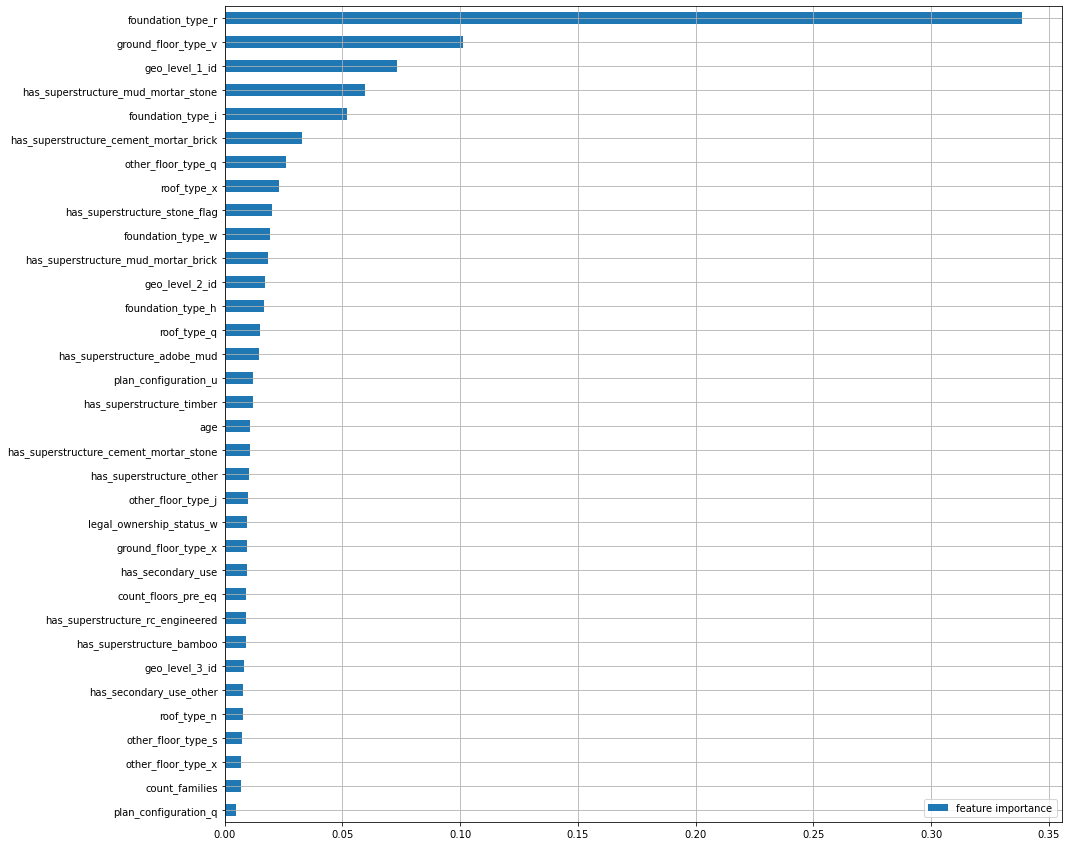

In [112]:
df = pd.DataFrame(columns=X_train_selected.columns)
df = df.T

df['feature importance'] = selection_model.feature_importances_

top_features = df.sort_values('feature importance')

top_features.plot.barh(figsize = (15,15), grid=True)

In [119]:
top_features.index.to_list()[::-1]

['foundation_type_r',
 'ground_floor_type_v',
 'geo_level_1_id',
 'has_superstructure_mud_mortar_stone',
 'foundation_type_i',
 'has_superstructure_cement_mortar_brick',
 'other_floor_type_q',
 'roof_type_x',
 'has_superstructure_stone_flag',
 'foundation_type_w',
 'has_superstructure_mud_mortar_brick',
 'geo_level_2_id',
 'foundation_type_h',
 'roof_type_q',
 'has_superstructure_adobe_mud',
 'plan_configuration_u',
 'has_superstructure_timber',
 'age',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_other',
 'other_floor_type_j',
 'legal_ownership_status_w',
 'ground_floor_type_x',
 'has_secondary_use',
 'count_floors_pre_eq',
 'has_superstructure_rc_engineered',
 'has_superstructure_bamboo',
 'geo_level_3_id',
 'has_secondary_use_other',
 'roof_type_n',
 'other_floor_type_s',
 'other_floor_type_x',
 'count_families',
 'plan_configuration_q']

In [123]:
X_train[top_features.index.to_list()[::-1]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208480 entries, 1020818 to 52856
Data columns (total 34 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   foundation_type_r                       208480 non-null  uint8
 1   ground_floor_type_v                     208480 non-null  uint8
 2   geo_level_1_id                          208480 non-null  int8 
 3   has_superstructure_mud_mortar_stone     208480 non-null  bool 
 4   foundation_type_i                       208480 non-null  uint8
 5   has_superstructure_cement_mortar_brick  208480 non-null  bool 
 6   other_floor_type_q                      208480 non-null  uint8
 7   roof_type_x                             208480 non-null  uint8
 8   has_superstructure_stone_flag           208480 non-null  bool 
 9   foundation_type_w                       208480 non-null  uint8
 10  has_superstructure_mud_mortar_brick     208480 non-null  bool 


In [4]:
feature_importance = ['foundation_type_r',
 'ground_floor_type_v',
 'geo_level_1_id',
 'has_superstructure_mud_mortar_stone',
 'foundation_type_i',
 'has_superstructure_cement_mortar_brick',
 'other_floor_type_q',
 'roof_type_x',
 'has_superstructure_stone_flag',
 'foundation_type_w',
 'has_superstructure_mud_mortar_brick',
 'geo_level_2_id',
 'foundation_type_h',
 'roof_type_q',
 'has_superstructure_adobe_mud',
 'plan_configuration_u',
 'has_superstructure_timber',
 'age',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_other',
 'other_floor_type_j',
 'legal_ownership_status_w',
 'ground_floor_type_x',
 'has_secondary_use',
 'count_floors_pre_eq',
 'has_superstructure_rc_engineered',
 'has_superstructure_bamboo',
 'geo_level_3_id',
 'has_secondary_use_other',
 'roof_type_n',
 'other_floor_type_s',
 'other_floor_type_x',
 'count_families',
 'plan_configuration_q']

In [5]:
X = X[feature_importance]
X

,foundation_type_r,ground_floor_type_v,geo_level_1_id,has_superstructure_mud_mortar_stone,foundation_type_i,has_superstructure_cement_mortar_brick,other_floor_type_q,roof_type_x,has_superstructure_stone_flag,foundation_type_w,...,count_floors_pre_eq,has_superstructure_rc_engineered,has_superstructure_bamboo,geo_level_3_id,has_secondary_use_other,roof_type_n,other_floor_type_s,other_floor_type_x,count_families,plan_configuration_q
building_id,,,,,,,,,,,,,,,,,,,,,
802906,1,0,6,True,0,False,1,0,False,0,...,2,False,False,12198,False,1,0,0,1,0
28830,1,0,8,True,0,False,1,0,False,0,...,2,False,False,2812,False,1,0,0,1,0
94947,1,0,21,True,0,False,0,0,False,0,...,2,False,False,8973,False,1,0,1,1,0
590882,1,0,22,True,0,False,0,0,False,0,...,2,False,True,10694,False,1,0,1,1,0
201944,1,0,11,False,0,False,0,0,False,0,...,3,False,False,1488,False,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,1,0,25,True,0,False,0,0,False,0,...,1,False,False,1621,False,1,0,0,1,1
669485,1,0,17,True,0,False,1,0,False,0,...,2,False,False,2060,False,1,0,0,1,0
602512,1,0,17,True,0,False,1,0,False,0,...,3,False,False,8163,False,0,0,0,1,0


In [20]:
X.columns

Index(['foundation_type_r', 'ground_floor_type_v', 'geo_level_1_id',
       'has_superstructure_mud_mortar_stone', 'foundation_type_i',
       'has_superstructure_cement_mortar_brick', 'other_floor_type_q',
       'roof_type_x', 'has_superstructure_stone_flag', 'foundation_type_w',
       'has_superstructure_mud_mortar_brick', 'geo_level_2_id',
       'foundation_type_h', 'roof_type_q', 'has_superstructure_adobe_mud',
       'plan_configuration_u', 'has_superstructure_timber', 'age',
       'has_superstructure_cement_mortar_stone', 'has_superstructure_other',
       'other_floor_type_j', 'legal_ownership_status_w', 'ground_floor_type_x',
       'has_secondary_use', 'count_floors_pre_eq',
       'has_superstructure_rc_engineered', 'has_superstructure_bamboo',
       'geo_level_3_id', 'has_secondary_use_other', 'roof_type_n',
       'other_floor_type_s', 'other_floor_type_x', 'count_families',
       'plan_configuration_q'],
      dtype='object')

In [6]:
# age x count_floors_pre_eq

X['age_mean_count_floors'] = X.groupby('count_floors_pre_eq')['age'].transform('mean')
X['age_min_count_floors'] = X.groupby('count_floors_pre_eq')['age'].transform('min')
X['age_max_count_floors'] = X.groupby('count_floors_pre_eq')['age'].transform('max')
X['age_std_count_floors'] = X.groupby('count_floors_pre_eq')['age'].transform('std')
X

,foundation_type_r,ground_floor_type_v,geo_level_1_id,has_superstructure_mud_mortar_stone,foundation_type_i,has_superstructure_cement_mortar_brick,other_floor_type_q,roof_type_x,has_superstructure_stone_flag,foundation_type_w,...,has_secondary_use_other,roof_type_n,other_floor_type_s,other_floor_type_x,count_families,plan_configuration_q,age_mean_count_floors,age_min_count_floors,age_max_count_floors,age_std_count_floors
building_id,,,,,,,,,,,,,,,,,,,,,
802906,1,0,6,True,0,False,1,0,False,0,...,False,1,0,0,1,0,25.761287,0,995,74.424994
28830,1,0,8,True,0,False,1,0,False,0,...,False,1,0,0,1,0,25.761287,0,995,74.424994
94947,1,0,21,True,0,False,0,0,False,0,...,False,1,0,1,1,0,25.761287,0,995,74.424994
590882,1,0,22,True,0,False,0,0,False,0,...,False,1,0,1,1,0,25.761287,0,995,74.424994
201944,1,0,11,False,0,False,0,0,False,0,...,False,1,0,1,1,0,30.157686,0,995,72.137833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,1,0,25,True,0,False,0,0,False,0,...,False,1,0,0,1,1,17.819292,0,995,65.124222
669485,1,0,17,True,0,False,1,0,False,0,...,False,1,0,0,1,0,25.761287,0,995,74.424994
602512,1,0,17,True,0,False,1,0,False,0,...,False,0,0,0,1,0,30.157686,0,995,72.137833


In [7]:
# count_families x count_floors_pre_eq
# Hacer antes de binning

X['families_mean_count_floors'] = X.groupby('count_floors_pre_eq')['count_families'].transform('mean')
X['families_min_count_floors'] = X.groupby('count_floors_pre_eq')['count_families'].transform('min')
X['families_max_count_floors'] = X.groupby('count_floors_pre_eq')['count_families'].transform('max')
X['families_std_count_floors'] = X.groupby('count_floors_pre_eq')['count_families'].transform('std')
X['families_per_floor'] = X.count_families / X.count_floors_pre_eq
X

,foundation_type_r,ground_floor_type_v,geo_level_1_id,has_superstructure_mud_mortar_stone,foundation_type_i,has_superstructure_cement_mortar_brick,other_floor_type_q,roof_type_x,has_superstructure_stone_flag,foundation_type_w,...,plan_configuration_q,age_mean_count_floors,age_min_count_floors,age_max_count_floors,age_std_count_floors,families_mean_count_floors,families_min_count_floors,families_max_count_floors,families_std_count_floors,families_per_floor
building_id,,,,,,,,,,,,,,,,,,,,,
802906,1,0,6,True,0,False,1,0,False,0,...,0,25.761287,0,995,74.424994,0.974161,0,9,0.386251,0.500000
28830,1,0,8,True,0,False,1,0,False,0,...,0,25.761287,0,995,74.424994,0.974161,0,9,0.386251,0.500000
94947,1,0,21,True,0,False,0,0,False,0,...,0,25.761287,0,995,74.424994,0.974161,0,9,0.386251,0.500000
590882,1,0,22,True,0,False,0,0,False,0,...,0,25.761287,0,995,74.424994,0.974161,0,9,0.386251,0.500000
201944,1,0,11,False,0,False,0,0,False,0,...,0,30.157686,0,995,72.137833,1.039376,0,9,0.486323,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,1,0,25,True,0,False,0,0,False,0,...,1,17.819292,0,995,65.124222,0.929502,0,9,0.368049,1.000000
669485,1,0,17,True,0,False,1,0,False,0,...,0,25.761287,0,995,74.424994,0.974161,0,9,0.386251,0.500000
602512,1,0,17,True,0,False,1,0,False,0,...,0,30.157686,0,995,72.137833,1.039376,0,9,0.486323,0.333333


In [53]:
# Concatenacion de categoricas
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 43 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   foundation_type_r                       260601 non-null  uint8  
 1   ground_floor_type_v                     260601 non-null  uint8  
 2   geo_level_1_id                          260601 non-null  int8   
 3   has_superstructure_mud_mortar_stone     260601 non-null  bool   
 4   foundation_type_i                       260601 non-null  uint8  
 5   has_superstructure_cement_mortar_brick  260601 non-null  bool   
 6   other_floor_type_q                      260601 non-null  uint8  
 7   roof_type_x                             260601 non-null  uint8  
 8   has_superstructure_stone_flag           260601 non-null  bool   
 9   foundation_type_w                       260601 non-null  uint8  
 10  has_superstructure_mud_mortar_brick    

In [8]:
# age x geo_level

X['age_mean_geo_1'] = X.groupby('geo_level_1_id')['age'].transform('mean')
X['age_min_geo_1'] = X.groupby('geo_level_1_id')['age'].transform('min')
X['age_max_geo_1'] = X.groupby('geo_level_1_id')['age'].transform('max')
X['age_std_geo_1'] = X.groupby('geo_level_1_id')['age'].transform('std')
X['age_mean_geo_2'] = X.groupby('geo_level_2_id')['age'].transform('mean')
X['age_min_geo_2'] = X.groupby('geo_level_2_id')['age'].transform('min')
X['age_max_geo_2'] = X.groupby('geo_level_2_id')['age'].transform('max')
X['age_std_geo_2'] = X.groupby('geo_level_2_id')['age'].transform('std')
X['age_mean_geo_3'] = X.groupby('geo_level_3_id')['age'].transform('mean')
X['age_min_geo_3'] = X.groupby('geo_level_3_id')['age'].transform('min')
X['age_max_geo_3'] = X.groupby('geo_level_3_id')['age'].transform('max')
X['age_std_geo_3'] = X.groupby('geo_level_3_id')['age'].transform('std')
X

,foundation_type_r,ground_floor_type_v,geo_level_1_id,has_superstructure_mud_mortar_stone,foundation_type_i,has_superstructure_cement_mortar_brick,other_floor_type_q,roof_type_x,has_superstructure_stone_flag,foundation_type_w,...,age_max_geo_1,age_std_geo_1,age_mean_geo_2,age_min_geo_2,age_max_geo_2,age_std_geo_2,age_mean_geo_3,age_min_geo_3,age_max_geo_3,age_std_geo_3
building_id,,,,,,,,,,,,,,,,,,,,,
802906,1,0,6,True,0,False,1,0,False,0,...,995,98.992496,22.203704,0,80,15.748228,23.378378,0,80,15.548046
28830,1,0,8,True,0,False,1,0,False,0,...,995,60.777728,17.311558,0,70,15.014586,13.750000,0,60,13.354150
94947,1,0,21,True,0,False,0,0,False,0,...,995,56.480316,20.411932,0,200,21.863528,30.845588,0,200,38.555180
590882,1,0,22,True,0,False,0,0,False,0,...,995,87.128742,18.390244,0,55,9.253717,17.258065,10,40,8.547778
201944,1,0,11,False,0,False,0,0,False,0,...,995,68.150698,36.917148,0,995,49.058492,30.204918,0,80,17.301382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,1,0,25,True,0,False,0,0,False,0,...,995,113.524267,26.163793,0,100,20.948776,26.785714,5,60,18.770593
669485,1,0,17,True,0,False,1,0,False,0,...,995,55.954313,19.214559,0,90,15.040201,16.734694,0,45,11.436009
602512,1,0,17,True,0,False,1,0,False,0,...,995,55.954313,21.021021,0,80,15.259093,28.181818,5,70,17.220244


In [9]:
# count_families x geo_level

X['families_mean_geo_1'] = X.groupby('geo_level_1_id')['count_families'].transform('mean')
X['families_min_geo_1'] = X.groupby('geo_level_1_id')['count_families'].transform('min')
X['families_max_geo_1'] = X.groupby('geo_level_1_id')['count_families'].transform('max')
X['families_std_geo_1'] = X.groupby('geo_level_1_id')['count_families'].transform('std')
X['families_mean_geo_2'] = X.groupby('geo_level_2_id')['count_families'].transform('mean')
X['families_min_geo_2'] = X.groupby('geo_level_2_id')['count_families'].transform('min')
X['families_max_geo_2'] = X.groupby('geo_level_2_id')['count_families'].transform('max')
X['families_std_geo_2'] = X.groupby('geo_level_2_id')['count_families'].transform('std')
X['families_mean_geo_3'] = X.groupby('geo_level_3_id')['count_families'].transform('mean')
X['families_min_geo_3'] = X.groupby('geo_level_3_id')['count_families'].transform('min')
X['families_max_geo_3'] = X.groupby('geo_level_3_id')['count_families'].transform('max')
X['families_std_geo_3'] = X.groupby('geo_level_3_id')['count_families'].transform('std')
X

,foundation_type_r,ground_floor_type_v,geo_level_1_id,has_superstructure_mud_mortar_stone,foundation_type_i,has_superstructure_cement_mortar_brick,other_floor_type_q,roof_type_x,has_superstructure_stone_flag,foundation_type_w,...,families_max_geo_1,families_std_geo_1,families_mean_geo_2,families_min_geo_2,families_max_geo_2,families_std_geo_2,families_mean_geo_3,families_min_geo_3,families_max_geo_3,families_std_geo_3
building_id,,,,,,,,,,,,,,,,,,,,,
802906,1,0,6,True,0,False,1,0,False,0,...,5,0.469136,0.992593,0,2,0.272570,0.972973,0,1,0.164399
28830,1,0,8,True,0,False,1,0,False,0,...,5,0.399080,0.989950,0,2,0.173786,1.062500,1,2,0.250000
94947,1,0,21,True,0,False,0,0,False,0,...,6,0.622270,1.093750,0,6,0.716702,1.169118,0,4,0.830485
590882,1,0,22,True,0,False,0,0,False,0,...,4,0.241041,1.004878,1,2,0.069843,1.000000,1,1,0.000000
201944,1,0,11,False,0,False,0,0,False,0,...,5,0.401610,1.076108,0,4,0.446769,1.016393,1,2,0.127507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,1,0,25,True,0,False,0,0,False,0,...,3,0.190002,1.000000,0,2,0.131876,1.000000,1,1,0.000000
669485,1,0,17,True,0,False,1,0,False,0,...,7,0.459095,0.896552,0,2,0.393245,0.938776,0,2,0.316765
602512,1,0,17,True,0,False,1,0,False,0,...,7,0.459095,1.051051,0,3,0.459610,1.090909,0,2,0.526361


In [10]:
# Correr al final para eliminar columnas con ceros
X = X.loc[:, ~(X == 0).all(axis=0)]
X

,foundation_type_r,ground_floor_type_v,geo_level_1_id,has_superstructure_mud_mortar_stone,foundation_type_i,has_superstructure_cement_mortar_brick,other_floor_type_q,roof_type_x,has_superstructure_stone_flag,foundation_type_w,...,families_max_geo_1,families_std_geo_1,families_mean_geo_2,families_min_geo_2,families_max_geo_2,families_std_geo_2,families_mean_geo_3,families_min_geo_3,families_max_geo_3,families_std_geo_3
building_id,,,,,,,,,,,,,,,,,,,,,
802906,1,0,6,True,0,False,1,0,False,0,...,5,0.469136,0.992593,0,2,0.272570,0.972973,0,1,0.164399
28830,1,0,8,True,0,False,1,0,False,0,...,5,0.399080,0.989950,0,2,0.173786,1.062500,1,2,0.250000
94947,1,0,21,True,0,False,0,0,False,0,...,6,0.622270,1.093750,0,6,0.716702,1.169118,0,4,0.830485
590882,1,0,22,True,0,False,0,0,False,0,...,4,0.241041,1.004878,1,2,0.069843,1.000000,1,1,0.000000
201944,1,0,11,False,0,False,0,0,False,0,...,5,0.401610,1.076108,0,4,0.446769,1.016393,1,2,0.127507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,1,0,25,True,0,False,0,0,False,0,...,3,0.190002,1.000000,0,2,0.131876,1.000000,1,1,0.000000
669485,1,0,17,True,0,False,1,0,False,0,...,7,0.459095,0.896552,0,2,0.393245,0.938776,0,2,0.316765
602512,1,0,17,True,0,False,1,0,False,0,...,7,0.459095,1.051051,0,3,0.459610,1.090909,0,2,0.526361


In [11]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [12]:
y_train = y_train-1
y_valid = y_valid-1

In [13]:
model = xgb.XGBClassifier(use_label_encoder=False)

model.fit(X_train, y_train)

[03:10:50] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [14]:
preds = model.predict(X_valid)

preds

array([0, 1, 0, ..., 1, 1, 1])

In [17]:
score = f1_score(y_valid, preds, average='micro')
print('Validation Score:', score)

Validation Score: 0.7376105600429769


In [18]:
score = f1_score(y_train, model.predict(X_train), average='micro')
print('Train Score:', score)

Train Score: 0.7596987720644665


In [20]:
bool_cols = []
for col in X.columns:
    if(X[col].dtype == np.uint8 or X[col].dtype == bool):
          bool_cols.append(col)
bool_cols

['foundation_type_r',
 'ground_floor_type_v',
 'has_superstructure_mud_mortar_stone',
 'foundation_type_i',
 'has_superstructure_cement_mortar_brick',
 'other_floor_type_q',
 'roof_type_x',
 'has_superstructure_stone_flag',
 'foundation_type_w',
 'has_superstructure_mud_mortar_brick',
 'foundation_type_h',
 'roof_type_q',
 'has_superstructure_adobe_mud',
 'plan_configuration_u',
 'has_superstructure_timber',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_other',
 'other_floor_type_j',
 'legal_ownership_status_w',
 'ground_floor_type_x',
 'has_secondary_use',
 'has_superstructure_rc_engineered',
 'has_superstructure_bamboo',
 'has_secondary_use_other',
 'roof_type_n',
 'other_floor_type_s',
 'other_floor_type_x',
 'plan_configuration_q']

In [23]:
prueba = bool_cols[:10]
prueba

['foundation_type_r',
 'ground_floor_type_v',
 'has_superstructure_mud_mortar_stone',
 'foundation_type_i',
 'has_superstructure_cement_mortar_brick',
 'other_floor_type_q',
 'roof_type_x',
 'has_superstructure_stone_flag',
 'foundation_type_w',
 'has_superstructure_mud_mortar_brick']

In [24]:
for a in prueba:
    for b in prueba:
        if a != b:
            X[a+b] = X[a] & X[b]
X.info()

<ipython-input-24-1a7ed768f1cb>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[a+b] = X[a] & X[b]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Columns: 155 entries, foundation_type_r to has_superstructure_mud_mortar_brickfoundation_type_w
dtypes: bool(72), float64(17), int16(10), int8(10), uint8(46)
memory usage: 72.6 MB


In [25]:
# Correr al final para eliminar columnas con ceros
X = X.loc[:, ~(X == 0).all(axis=0)]
X

,foundation_type_r,ground_floor_type_v,geo_level_1_id,has_superstructure_mud_mortar_stone,foundation_type_i,has_superstructure_cement_mortar_brick,other_floor_type_q,roof_type_x,has_superstructure_stone_flag,foundation_type_w,...,foundation_type_whas_superstructure_mud_mortar_brick,has_superstructure_mud_mortar_brickfoundation_type_r,has_superstructure_mud_mortar_brickground_floor_type_v,has_superstructure_mud_mortar_brickhas_superstructure_mud_mortar_stone,has_superstructure_mud_mortar_brickfoundation_type_i,has_superstructure_mud_mortar_brickhas_superstructure_cement_mortar_brick,has_superstructure_mud_mortar_brickother_floor_type_q,has_superstructure_mud_mortar_brickroof_type_x,has_superstructure_mud_mortar_brickhas_superstructure_stone_flag,has_superstructure_mud_mortar_brickfoundation_type_w
building_id,,,,,,,,,,,,,,,,,,,,,
802906,1,0,6,True,0,False,1,0,False,0,...,False,False,False,False,False,False,False,False,False,False
28830,1,0,8,True,0,False,1,0,False,0,...,False,False,False,False,False,False,False,False,False,False
94947,1,0,21,True,0,False,0,0,False,0,...,False,False,False,False,False,False,False,False,False,False
590882,1,0,22,True,0,False,0,0,False,0,...,False,False,False,False,False,False,False,False,False,False
201944,1,0,11,False,0,False,0,0,False,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
688636,1,0,25,True,0,False,0,0,False,0,...,False,False,False,False,False,False,False,False,False,False
669485,1,0,17,True,0,False,1,0,False,0,...,False,False,False,False,False,False,False,False,False,False
602512,1,0,17,True,0,False,1,0,False,0,...,False,False,False,False,False,False,False,False,False,False


In [27]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [28]:
y_train = y_train-1
y_valid = y_valid-1

In [29]:
model = xgb.XGBClassifier(use_label_encoder=False)

model.fit(X_train, y_train)

[03:24:15] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [30]:
preds = model.predict(X_valid)

preds

array([0, 1, 0, ..., 1, 1, 1])

In [31]:
score = f1_score(y_valid, preds, average='micro')
print('Validation Score:', score)

Validation Score: 0.7370541624297308


In [32]:
score = f1_score(y_train, model.predict(X_train), average='micro')
print('Train Score:', score)

Train Score: 0.7607828089025326


In [36]:
np.sort(model.feature_importances_)[-10:]

array([0.01758401, 0.03038793, 0.03629411, 0.03800349, 0.04677207,
       0.05049823, 0.06976071, 0.08145283, 0.1146377 , 0.17626528],
      dtype=float32)

<AxesSubplot:>

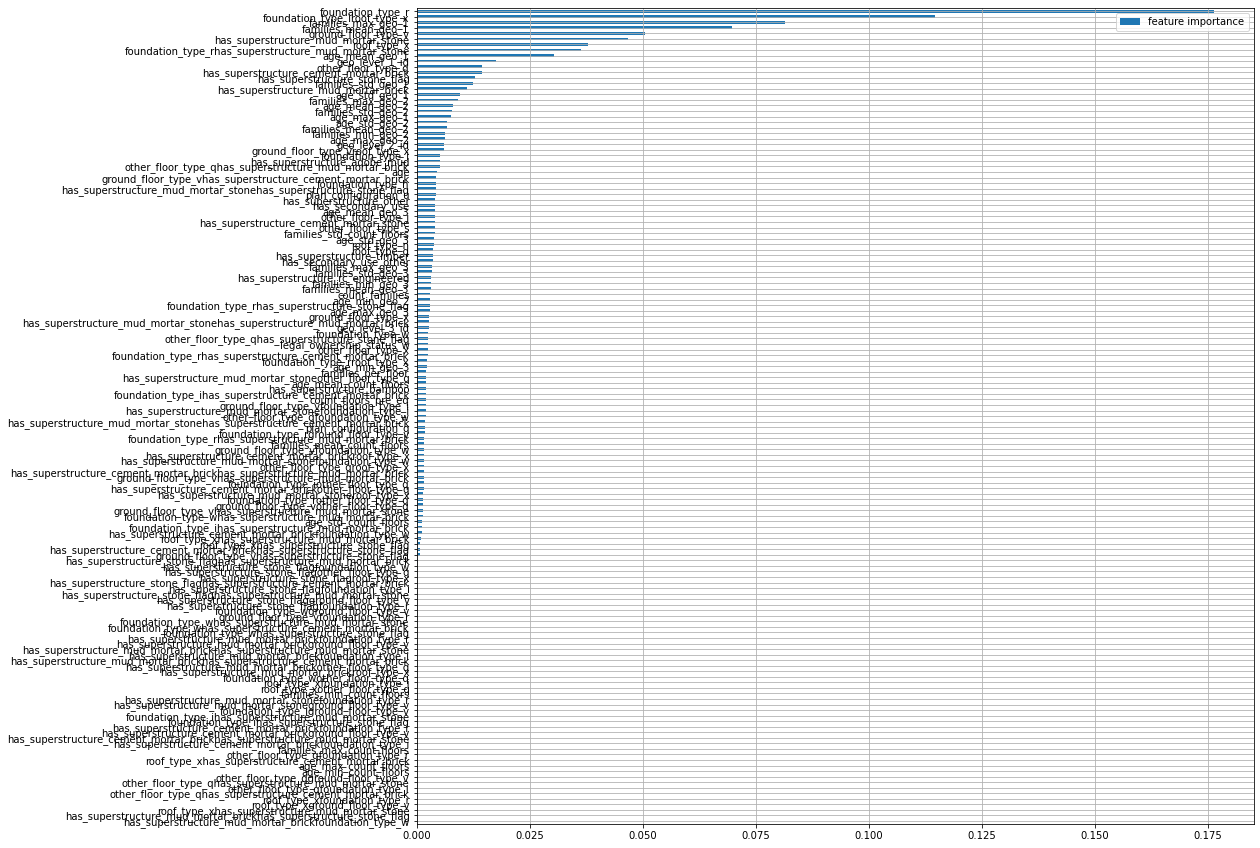

In [41]:
df = pd.DataFrame(columns=X_train.columns)
df = df.T

df['feature importance'] = model.feature_importances_

top_features = df.sort_values('feature importance')

top_features.plot.barh(figsize = (15,15), grid=True)

In [50]:
top_features.index.to_list()[-10:]

['geo_level_1_id',
 'age_mean_geo_1',
 'foundation_type_rhas_superstructure_mud_mortar_stone',
 'roof_type_x',
 'has_superstructure_mud_mortar_stone',
 'ground_floor_type_v',
 'families_mean_geo_1',
 'families_max_geo_1',
 'foundation_type_iroof_type_x',
 'foundation_type_r']

In [51]:
len(top_features.index.to_list())

147

In [52]:
%%time
for i in range(10,147,10):
    print('Top %d features' % (i))
    prueba = top_features.index.to_list()[-i:]
    X_temp = X[prueba]
    X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y, test_size=0.2, random_state=123)

    y_train = y_train-1
    y_valid = y_valid-1

    model = xgb.XGBClassifier(use_label_encoder=False)

    model.fit(X_train, y_train)

    preds = model.predict(X_valid)

    print(preds)

    score = f1_score(y_valid, preds, average='micro')
    print('Validation Score:', score)

    score = f1_score(y_train, model.predict(X_train), average='micro')
    print('Train Score:', score)

Top 10 features
[04:15:54] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0 1 0 ... 2 1 1]
Validation Score: 0.6622474626350223
Train Score: 0.6654787029930929
Top 20 features
[04:17:08] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0 1 0 ... 2 1 1]
Validation Score: 0.7158151225034056
Train Score: 0.7232876055257099
Top 30 features
[04:19:28] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objecti

In [53]:
#60 features es un buen spot

prueba = top_features.index.to_list()[-60:]
X_temp = X[prueba]
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y, test_size=0.2, random_state=123)

y_train = y_train-1
y_valid = y_valid-1

model = xgb.XGBClassifier(use_label_encoder=False, objective='multi:softmax', eval_metric='merror')

model.fit(X_train, y_train)

preds = model.predict(X_valid)

print(preds)

score = f1_score(y_valid, preds, average='micro')
print('Validation Score:', score)

score = f1_score(y_train, model.predict(X_train), average='micro')
print('Train Score:', score)

[0 1 0 ... 2 1 1]
Validation Score: 0.7377448629151397
Train Score: 0.7600729086722947


In [54]:
prueba

['other_floor_type_qhas_superstructure_stone_flag',
 'foundation_type_w',
 'geo_level_3_id',
 'has_superstructure_mud_mortar_stonehas_superstructure_mud_mortar_brick',
 'ground_floor_type_x',
 'age_max_geo_3',
 'foundation_type_rhas_superstructure_stone_flag',
 'age_min_geo_2',
 'count_families',
 'families_mean_geo_3',
 'families_min_geo_3',
 'has_superstructure_rc_engineered',
 'families_std_geo_3',
 'families_max_geo_3',
 'has_secondary_use_other',
 'has_superstructure_timber',
 'roof_type_q',
 'roof_type_n',
 'age_std_geo_3',
 'families_std_count_floors',
 'other_floor_type_s',
 'has_superstructure_cement_mortar_stone',
 'other_floor_type_j',
 'age_mean_geo_3',
 'has_secondary_use',
 'has_superstructure_other',
 'plan_configuration_u',
 'has_superstructure_mud_mortar_stonehas_superstructure_stone_flag',
 'foundation_type_h',
 'ground_floor_type_vhas_superstructure_cement_mortar_brick',
 'age',
 'other_floor_type_qhas_superstructure_mud_mortar_brick',
 'has_superstructure_adobe_mud'

In [55]:
test = pd.read_pickle('../cleaned_test.pkl')
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86868 entries, 0 to 86867
Data columns (total 39 columns):
 #   Column                                  Non-Null Count  Dtype   
---  ------                                  --------------  -----   
 0   building_id                             86868 non-null  int32   
 1   geo_level_1_id                          86868 non-null  int8    
 2   geo_level_2_id                          86868 non-null  int16   
 3   geo_level_3_id                          86868 non-null  int16   
 4   count_floors_pre_eq                     86868 non-null  int8    
 5   age                                     86868 non-null  int16   
 6   area_percentage                         86868 non-null  int8    
 7   height_percentage                       86868 non-null  int8    
 8   land_surface_condition                  86868 non-null  category
 9   foundation_type                         86868 non-null  category
 10  roof_type                               86868 

In [56]:
cat_cols = test.select_dtypes(include=['category']).columns.to_list()


oneHot = pd.get_dummies(test[cat_cols], prefix=cat_cols)


test = test.drop(columns=cat_cols)


test = pd.concat([test, oneHot], axis=1)


#oneHot = pd.get_dummies(test[cat_cols], prefix=cat_cols)

#test = test.drop(columns=cat_cols)

#test = pd.concat([test, oneHot], axis=1)
#y = train.damage_grade
#X = train.drop(columns='damage_grade')
test = test.set_index('building_id')

#X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=123)

In [24]:
test = test[feature_importance]

# age x count_floors_pre_eq

test['age_mean_count_floors'] = test.groupby('count_floors_pre_eq')['age'].transform('mean')
test['age_min_count_floors'] = test.groupby('count_floors_pre_eq')['age'].transform('min')
test['age_max_count_floors'] = test.groupby('count_floors_pre_eq')['age'].transform('max')
test['age_std_count_floors'] = test.groupby('count_floors_pre_eq')['age'].transform('std')

# count_families x count_floors_pre_eq
# Hacer antes de binning

test['families_mean_count_floors'] = test.groupby('count_floors_pre_eq')['count_families'].transform('mean')
test['families_min_count_floors'] = test.groupby('count_floors_pre_eq')['count_families'].transform('min')
test['families_max_count_floors'] = test.groupby('count_floors_pre_eq')['count_families'].transform('max')
test['families_std_count_floors'] = test.groupby('count_floors_pre_eq')['count_families'].transform('std')
test['families_per_floor'] = test.count_families / test.count_floors_pre_eq

# Concatenacion de categoricas

# age x geo_level

test['age_mean_geo_1'] = test.groupby('geo_level_1_id')['age'].transform('mean')
test['age_min_geo_1'] = test.groupby('geo_level_1_id')['age'].transform('min')
test['age_max_geo_1'] = test.groupby('geo_level_1_id')['age'].transform('max')
test['age_std_geo_1'] = test.groupby('geo_level_1_id')['age'].transform('std')
test['age_mean_geo_2'] = test.groupby('geo_level_2_id')['age'].transform('mean')
test['age_min_geo_2'] = test.groupby('geo_level_2_id')['age'].transform('min')
test['age_max_geo_2'] = test.groupby('geo_level_2_id')['age'].transform('max')
test['age_std_geo_2'] = test.groupby('geo_level_2_id')['age'].transform('std')
test['age_mean_geo_3'] = test.groupby('geo_level_3_id')['age'].transform('mean')
test['age_min_geo_3'] = test.groupby('geo_level_3_id')['age'].transform('min')
test['age_max_geo_3'] = test.groupby('geo_level_3_id')['age'].transform('max')
test['age_std_geo_3'] = test.groupby('geo_level_3_id')['age'].transform('std')

# count_families x geo_level

test['families_mean_geo_1'] = test.groupby('geo_level_1_id')['count_families'].transform('mean')
test['families_min_geo_1'] = test.groupby('geo_level_1_id')['count_families'].transform('min')
test['families_max_geo_1'] = test.groupby('geo_level_1_id')['count_families'].transform('max')
test['families_std_geo_1'] = test.groupby('geo_level_1_id')['count_families'].transform('std')
test['families_mean_geo_2'] = test.groupby('geo_level_2_id')['count_families'].transform('mean')
test['families_min_geo_2'] = test.groupby('geo_level_2_id')['count_families'].transform('min')
test['families_max_geo_2'] = test.groupby('geo_level_2_id')['count_families'].transform('max')
test['families_std_geo_2'] = test.groupby('geo_level_2_id')['count_families'].transform('std')
test['families_mean_geo_3'] = test.groupby('geo_level_3_id')['count_families'].transform('mean')
test['families_min_geo_3'] = test.groupby('geo_level_3_id')['count_families'].transform('min')
test['families_max_geo_3'] = test.groupby('geo_level_3_id')['count_families'].transform('max')
test['families_std_geo_3'] = test.groupby('geo_level_3_id')['count_families'].transform('std')
test

In [63]:
test

,foundation_type_r,ground_floor_type_v,geo_level_1_id,has_superstructure_mud_mortar_stone,foundation_type_i,has_superstructure_cement_mortar_brick,other_floor_type_q,roof_type_x,has_superstructure_stone_flag,foundation_type_w,...,families_max_geo_1,families_std_geo_1,families_mean_geo_2,families_min_geo_2,families_max_geo_2,families_std_geo_2,families_mean_geo_3,families_min_geo_3,families_max_geo_3,families_std_geo_3
building_id,,,,,,,,,,,,,,,,,,,,,
300051,1,0,17,True,0,False,1,0,False,0,...,6,0.466235,1.022222,0,3,0.499495,1.000000,1,1,0.000000
99355,1,0,6,True,0,False,1,0,False,0,...,4,0.467171,0.815385,0,2,0.496623,1.000000,0,2,1.000000
890251,1,0,22,True,0,False,1,0,False,0,...,3,0.252916,1.000000,1,1,0.000000,1.000000,1,1,0.000000
745817,1,1,26,False,0,True,0,1,False,0,...,8,0.453931,1.072987,0,8,0.628107,1.105263,0,4,0.581436
421793,1,0,17,True,0,False,1,0,False,0,...,6,0.466235,1.048387,0,3,0.335223,1.000000,1,1,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,1,0,4,True,0,False,1,0,False,0,...,5,0.410295,1.114583,0,3,0.432126,1.100000,1,2,0.316228
663567,1,0,10,True,0,False,1,0,True,0,...,5,0.380106,1.028571,0,3,0.316065,1.000000,1,1,0.000000
1049160,1,0,22,True,0,False,0,0,False,0,...,3,0.252916,0.983607,0,1,0.128037,1.000000,1,1,0.000000


In [64]:
for a in bool_cols[:10]:
    for b in bool_cols[:10]:
        if a != b:
            test[a+b] = test[a] & test[b]
test

,foundation_type_r,ground_floor_type_v,geo_level_1_id,has_superstructure_mud_mortar_stone,foundation_type_i,has_superstructure_cement_mortar_brick,other_floor_type_q,roof_type_x,has_superstructure_stone_flag,foundation_type_w,...,foundation_type_whas_superstructure_mud_mortar_brick,has_superstructure_mud_mortar_brickfoundation_type_r,has_superstructure_mud_mortar_brickground_floor_type_v,has_superstructure_mud_mortar_brickhas_superstructure_mud_mortar_stone,has_superstructure_mud_mortar_brickfoundation_type_i,has_superstructure_mud_mortar_brickhas_superstructure_cement_mortar_brick,has_superstructure_mud_mortar_brickother_floor_type_q,has_superstructure_mud_mortar_brickroof_type_x,has_superstructure_mud_mortar_brickhas_superstructure_stone_flag,has_superstructure_mud_mortar_brickfoundation_type_w
building_id,,,,,,,,,,,,,,,,,,,,,
300051,1,0,17,True,0,False,1,0,False,0,...,False,False,False,False,False,False,False,False,False,False
99355,1,0,6,True,0,False,1,0,False,0,...,False,False,False,False,False,False,False,False,False,False
890251,1,0,22,True,0,False,1,0,False,0,...,False,False,False,False,False,False,False,False,False,False
745817,1,1,26,False,0,True,0,1,False,0,...,False,False,False,False,False,False,False,False,False,False
421793,1,0,17,True,0,False,1,0,False,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,1,0,4,True,0,False,1,0,False,0,...,False,False,False,False,False,False,False,False,False,False
663567,1,0,10,True,0,False,1,0,True,0,...,False,False,False,False,False,False,False,False,False,False
1049160,1,0,22,True,0,False,0,0,False,0,...,False,False,False,False,False,False,False,False,False,False


In [66]:
test = test[prueba]
test

,other_floor_type_qhas_superstructure_stone_flag,foundation_type_w,geo_level_3_id,has_superstructure_mud_mortar_stonehas_superstructure_mud_mortar_brick,ground_floor_type_x,age_max_geo_3,foundation_type_rhas_superstructure_stone_flag,age_min_geo_2,count_families,families_mean_geo_3,...,geo_level_1_id,age_mean_geo_1,foundation_type_rhas_superstructure_mud_mortar_stone,roof_type_x,has_superstructure_mud_mortar_stone,ground_floor_type_v,families_mean_geo_1,families_max_geo_1,foundation_type_iroof_type_x,foundation_type_r
building_id,,,,,,,,,,,,,,,,,,,,,
300051,False,0,11307,False,0,45,False,0,1,1.000000,...,17,22.799919,True,0,True,0,1.017713,6,0,1
99355,False,0,11987,False,0,60,False,0,1,1.000000,...,6,32.889931,True,0,True,0,0.930158,4,0,1
890251,False,0,10044,False,0,65,False,0,1,1.000000,...,22,26.222697,True,0,True,0,0.960114,3,0,1
745817,False,0,633,False,0,50,False,0,2,1.105263,...,26,23.041830,False,1,False,1,0.979559,8,0,1
421793,False,0,7970,False,0,60,False,0,1,1.000000,...,17,22.799919,True,0,True,0,1.017713,6,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310028,False,0,3623,False,0,80,False,0,1,1.100000,...,4,21.910503,True,0,True,0,0.940539,5,0,1
663567,True,0,11907,False,0,50,True,0,1,1.000000,...,10,22.223361,True,0,True,0,0.967896,5,0,1
1049160,False,0,7712,False,0,50,False,0,1,1.000000,...,22,26.222697,True,0,True,0,0.960114,3,0,1


In [67]:
preds = model.predict(test)
preds

array([2, 1, 1, ..., 1, 1, 1])

In [69]:
np.unique(preds)

array([0, 1, 2])

In [70]:
preds = preds+1
preds

array([3, 2, 2, ..., 2, 2, 2])

In [71]:
submission_format = pd.read_csv('../TP1/submission_format.csv', index_col='building_id')
submission_format

,damage_grade
building_id,
300051,1
99355,1
890251,1
745817,1
421793,1
...,...
310028,1
663567,1
1049160,1


In [73]:
my_submission = pd.DataFrame(data=preds, columns=submission_format.columns, index=submission_format.index)
my_submission

,damage_grade
building_id,
300051,3
99355,2
890251,2
745817,1
421793,3
...,...
310028,2
663567,3
1049160,2


In [74]:
my_submission.to_csv('Submits/FeatureEngineering.csv')

# Otras ideas

In [23]:
weights = train.damage_grade.value_counts(normalize=True).mul(100).to_frame()
weights

,damage_grade
2,56.891186
3,33.468022
1,9.640792


In [24]:
weights['weight'] = [1/5.6,1/3.3,1]
weights['weight']

2    0.178571
3    0.303030
1    1.000000
Name: weight, dtype: float64

In [25]:
def label_weight(row):
    if row['damage_grade'] == 1:
        return 1
    if row['damage_grade'] == 2:
        return 1/5.6
    else:
        return 1/3.3

In [26]:
train['weight'] = train.apply(lambda row: label_weight(row), axis=1)
train

,building_id,damage_grade,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,weight
0,802906,3,6,487,12198,2,30,6,5,t,...,False,False,False,False,False,False,False,False,False,0.303030
1,28830,2,8,900,2812,2,10,8,7,o,...,False,False,False,False,False,False,False,False,False,0.178571
2,94947,3,21,363,8973,2,10,5,5,t,...,False,False,False,False,False,False,False,False,False,0.303030
3,590882,2,22,418,10694,2,10,6,5,t,...,False,False,False,False,False,False,False,False,False,0.178571
4,201944,3,11,131,1488,3,30,8,9,t,...,False,False,False,False,False,False,False,False,False,0.303030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260596,688636,2,25,1335,1621,1,55,6,3,n,...,False,False,False,False,False,False,False,False,False,0.178571
260597,669485,3,17,715,2060,2,0,6,5,t,...,False,False,False,False,False,False,False,False,False,0.303030
260598,602512,3,17,51,8163,3,55,6,7,t,...,False,False,False,False,False,False,False,False,False,0.303030
260599,151409,2,26,39,1851,2,10,14,6,t,...,False,False,False,False,False,False,False,False,False,0.178571


In [8]:
num_cols = train.select_dtypes(include=['number']).columns.to_list()[2:]
num_cols

['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'count_families']

In [9]:
# altura / cantidad de pisos (altura de los pisos)
# area * altura (volumen)
# binning (0: 0 familias, 1: 1 familia, 2: mas de una familia)

In [10]:
train['floor_height'] = train['height_percentage'] / train['count_floors_pre_eq']
train['volumen_percentage'] = train['height_percentage'] * train['area_percentage']

bins = [0, 1, 2, 10]
labels = [0, 1, 2]
familias = pd.cut(train['count_families'], bins, right=False, labels=labels)
train['count_families'] = pd.to_numeric(familias, downcast="integer")

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Data columns (total 42 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   building_id                             260601 non-null  int32   
 1   damage_grade                            260601 non-null  int8    
 2   geo_level_1_id                          260601 non-null  int8    
 3   geo_level_2_id                          260601 non-null  int16   
 4   geo_level_3_id                          260601 non-null  int16   
 5   count_floors_pre_eq                     260601 non-null  int8    
 6   age                                     260601 non-null  int16   
 7   area_percentage                         260601 non-null  int8    
 8   height_percentage                       260601 non-null  int8    
 9   land_surface_condition                  260601 non-null  category
 10  foundation_type                 

In [14]:
bool_cols = train.select_dtypes(include=['bool']).columns.to_list()
bool_cols

['has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other',
 'has_secondary_use',
 'has_secondary_use_agriculture',
 'has_secondary_use_hotel',
 'has_secondary_use_rental',
 'has_secondary_use_institution',
 'has_secondary_use_school',
 'has_secondary_use_industry',
 'has_secondary_use_health_post',
 'has_secondary_use_gov_office',
 'has_secondary_use_use_police',
 'has_secondary_use_other']

In [15]:
# Concatenar las superestructuras (hay edificios que poseen mas de una)
# Concatenar los usos secundarios y las superestructuras (el daño varia segun la superestructura como mostre
#en el TP1)
# Al encodear estas concatenaciones me parece que hay que encodear como el promedio de datos que poseen esta
#caracteristica (no hacerlo por ahora)

In [16]:
# Concatenacion de superestructuras
superestructuras = bool_cols[:11]
for a in superestructuras:
    for b in superestructuras:
        if a != b:
            train[a+b] = train[a] & train[b]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Columns: 153 entries, building_id to has_superstructure_otherhas_superstructure_rc_engineered
dtypes: bool(132), category(8), float64(2), int16(3), int32(1), int8(7)
memory usage: 45.0 MB


In [17]:
# Concatenacion de usos secundarios y su superestructura
secondary_uses = bool_cols[12:]
for a in secondary_uses:
    for b in superestructuras:
        train[a+b] = train[a] & train[b]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 0 to 260600
Columns: 263 entries, building_id to has_secondary_use_otherhas_superstructure_other
dtypes: bool(242), category(8), float64(2), int16(3), int32(1), int8(7)
memory usage: 72.3 MB


In [18]:
train.transpose()

,0,1,2,3,4,5,6,7,8,9,...,260591,260592,260593,260594,260595,260596,260597,260598,260599,260600
building_id,802906,28830,94947,590882,201944,333020,728451,475515,441126,989500,...,560805,207683,226421,159555,827012,688636,669485,602512,151409,747594
damage_grade,3,2,3,2,3,2,3,1,2,1,...,3,2,2,2,3,2,3,3,2,3
geo_level_1_id,6,8,21,22,11,8,9,20,0,26,...,20,10,8,27,8,25,17,17,26,21
geo_level_2_id,487,900,363,418,131,558,475,323,757,886,...,368,1382,767,181,268,1335,715,51,39,9
geo_level_3_id,12198,2812,8973,10694,1488,6089,12066,12236,7219,994,...,5980,1903,8613,1537,4718,1621,2060,8163,1851,9101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
has_secondary_use_otherhas_superstructure_timber,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
has_secondary_use_otherhas_superstructure_bamboo,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
has_secondary_use_otherhas_superstructure_rc_non_engineered,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
has_secondary_use_otherhas_superstructure_rc_engineered,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [30]:
X_train_weight = X_train.weight
X_train = X_train.drop(columns='weight')
X_train_weight

building_id
1020818    0.178571
329236     0.178571
672989     0.303030
236246     0.303030
994471     0.178571
             ...   
441520     0.303030
46294      0.303030
480222     0.303030
765113     0.303030
52856      0.303030
Name: weight, Length: 208480, dtype: float64

In [31]:
X_valid_weight = X_valid.weight
X_valid = X_valid.drop(columns='weight')
X_valid_weight

building_id
214806     1.000000
861314     0.178571
235876     1.000000
416053     0.303030
833041     0.178571
             ...   
774769     0.303030
311094     0.178571
928155     0.178571
1047408    0.178571
958252     0.178571
Name: weight, Length: 52121, dtype: float64

In [43]:
model = xgb.XGBClassifier(use_label_encoder=False)

model.fit(X_train, y_train-1)

[04:24:32] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [44]:
preds = model.predict(X_valid)

preds

array([1, 1, 0, ..., 2, 1, 1])

In [45]:
score = f1_score(y_valid-1, preds, average='micro')
print('Validation Score:', score)

Validation Score: 0.7239692254561502


In [46]:
score = f1_score(y_train-1, model.predict(X_train), average='micro')
print('Train Score:', score)

Train Score: 0.7468534151957023


In [36]:
model = xgb.XGBClassifier(use_label_encoder=False)

model.fit(X_train, y_train-1, sample_weight=X_train_weight)

[03:47:17] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [37]:
preds = model.predict(X_valid)

preds

array([0, 2, 0, ..., 2, 1, 1])

In [38]:
y_valid

191442    1
39922     2
260497    1
175563    3
138080    2
         ..
221566    3
37817     2
256412    2
235921    2
47594     2
Name: damage_grade, Length: 52121, dtype: int8

In [39]:
score = f1_score(y_valid-1, preds, average='micro')
print('Validation Score:', score)

Validation Score: 0.6667945741639646


In [40]:
score = f1_score(y_train-1, model.predict(X_train), average='micro')
print('Train Score:', score)

Train Score: 0.6874568303914045


In [49]:
%matplotlib inline
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [50]:
df = pd.DataFrame(columns=X_train.columns)
df = df.T

In [51]:
df['feature importance'] = model.feature_importances_

In [52]:
top_features = df.sort_values('feature importance', ascending=False).head(35)
top_features

,feature importance
foundation_type_r,0.260049
ground_floor_type_v,0.076397
foundation_type_i,0.043475
has_superstructure_mud_mortar_stone,0.042185
geo_level_1_id,0.037204
has_superstructure_cement_mortar_brick,0.025482
other_floor_type_q,0.019120
roof_type_x,0.014531
has_superstructure_mud_mortar_brick,0.011500
has_superstructure_stone_flag,0.011482


<AxesSubplot:>

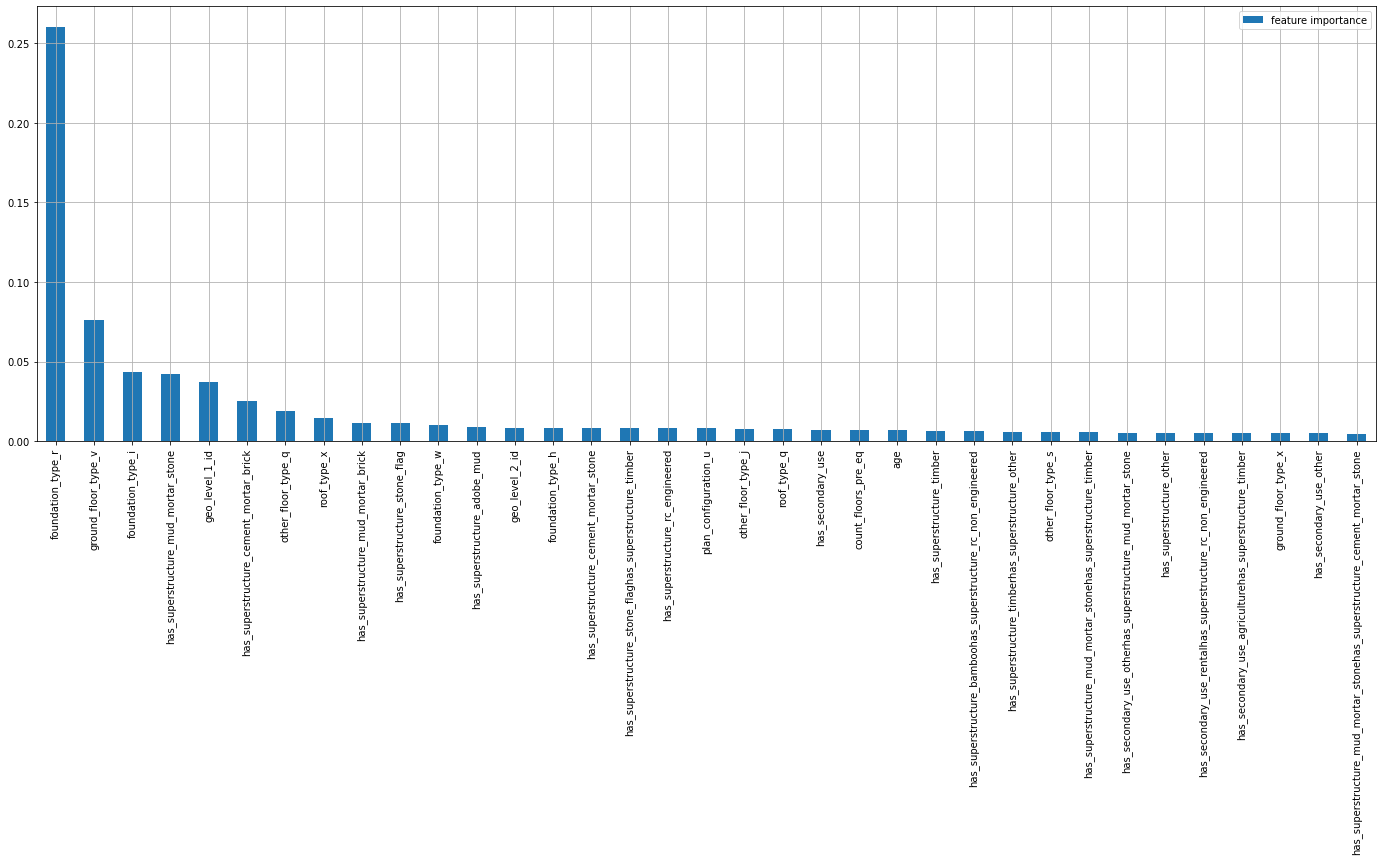

In [53]:
top_features.plot.bar(figsize = (24,8), grid=True)

In [ ]:
# Feature Selection
# https://www.kaggle.com/kashnitsky/topic-6-feature-engineering-and-feature-selection

In [64]:
#Es lo mismo que quedarme con las 34 de feature importance?
np.sort(model.feature_importances_)[-34:]

array([0.00538312, 0.00545936, 0.00549665, 0.00552121, 0.00579249,
       0.0058504 , 0.00626275, 0.00626875, 0.00691652, 0.00691934,
       0.00714282, 0.00743853, 0.00839879, 0.00846731, 0.00853421,
       0.00883039, 0.00918456, 0.00941799, 0.00997208, 0.01029828,
       0.01058916, 0.01150871, 0.0120591 , 0.01232713, 0.01365979,
       0.01426639, 0.02144272, 0.02229242, 0.0303362 , 0.0439993 ,
       0.05061791, 0.05194482, 0.09983043, 0.34617838], dtype=float32)

In [72]:
df = pd.DataFrame(columns=X_train.columns)
df = df.T
df['feature importance'] = model.feature_importances_
selected_features = df.sort_values('feature importance').iloc[-34:].index.to_list()
selected_features

['geo_level_3_id',
 'other_floor_type_s',
 'legal_ownership_status_w',
 'other_floor_type_x',
 'count_families',
 'has_superstructure_bamboo',
 'roof_type_n',
 'plan_configuration_q',
 'has_superstructure_other',
 'has_secondary_use_other',
 'ground_floor_type_x',
 'has_superstructure_rc_engineered',
 'count_floors_pre_eq',
 'has_secondary_use',
 'other_floor_type_j',
 'has_superstructure_timber',
 'has_superstructure_cement_mortar_stone',
 'age',
 'roof_type_q',
 'plan_configuration_u',
 'has_superstructure_adobe_mud',
 'geo_level_2_id',
 'foundation_type_w',
 'foundation_type_h',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_stone_flag',
 'roof_type_x',
 'other_floor_type_q',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_mud_mortar_stone',
 'geo_level_1_id',
 'foundation_type_i',
 'ground_floor_type_v',
 'foundation_type_r']

In [74]:
X_train_selected = X_train[selected_features]
X_train_selected

,geo_level_3_id,other_floor_type_s,legal_ownership_status_w,other_floor_type_x,count_families,has_superstructure_bamboo,roof_type_n,plan_configuration_q,has_superstructure_other,has_secondary_use_other,...,has_superstructure_mud_mortar_brick,has_superstructure_stone_flag,roof_type_x,other_floor_type_q,has_superstructure_cement_mortar_brick,has_superstructure_mud_mortar_stone,geo_level_1_id,foundation_type_i,ground_floor_type_v,foundation_type_r
building_id,,,,,,,,,,,,,,,,,,,,,
1020818,4190,0,0,0,1,False,1,0,False,False,...,False,False,0,1,False,True,0,0,0,1
329236,12014,0,0,0,1,False,1,0,False,False,...,False,False,0,0,False,True,10,0,0,1
672989,8232,0,0,0,2,False,0,0,False,False,...,False,False,0,1,False,True,17,0,0,1
236246,12448,0,0,0,1,False,1,0,False,False,...,False,False,0,1,False,True,10,0,0,1
994471,5339,0,0,0,1,False,1,0,False,False,...,False,False,0,0,False,True,26,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441520,10644,0,0,0,1,False,1,0,False,False,...,False,False,0,0,False,True,8,0,0,1
46294,4813,0,0,0,1,False,1,0,False,False,...,False,False,0,1,False,True,8,0,0,1
480222,4692,0,0,1,1,False,1,0,False,False,...,False,False,0,0,False,True,8,0,0,1


In [75]:
X_valid_selected = X_valid[selected_features]

In [76]:
# train model
selection_model = xgb.XGBClassifier(use_label_encoder=False)
selection_model.fit(X_train_selected, y_train)
# eval model
predictions = selection_model.predict(X_valid_selected)
score = f1_score(y_valid, predictions, average='micro')

[16:49:46] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [77]:
score

0.7256959766696726

In [91]:
#No, no es lo mismo

In [50]:
df = pd.DataFrame(columns=X_train.columns)
df = df.T

In [51]:
df['feature importance'] = model.feature_importances_

In [52]:
top_features = df.sort_values('feature importance', ascending=False).head(35)
top_features

,feature importance
foundation_type_r,0.260049
ground_floor_type_v,0.076397
foundation_type_i,0.043475
has_superstructure_mud_mortar_stone,0.042185
geo_level_1_id,0.037204
has_superstructure_cement_mortar_brick,0.025482
other_floor_type_q,0.019120
roof_type_x,0.014531
has_superstructure_mud_mortar_brick,0.011500
has_superstructure_stone_flag,0.011482


<AxesSubplot:>

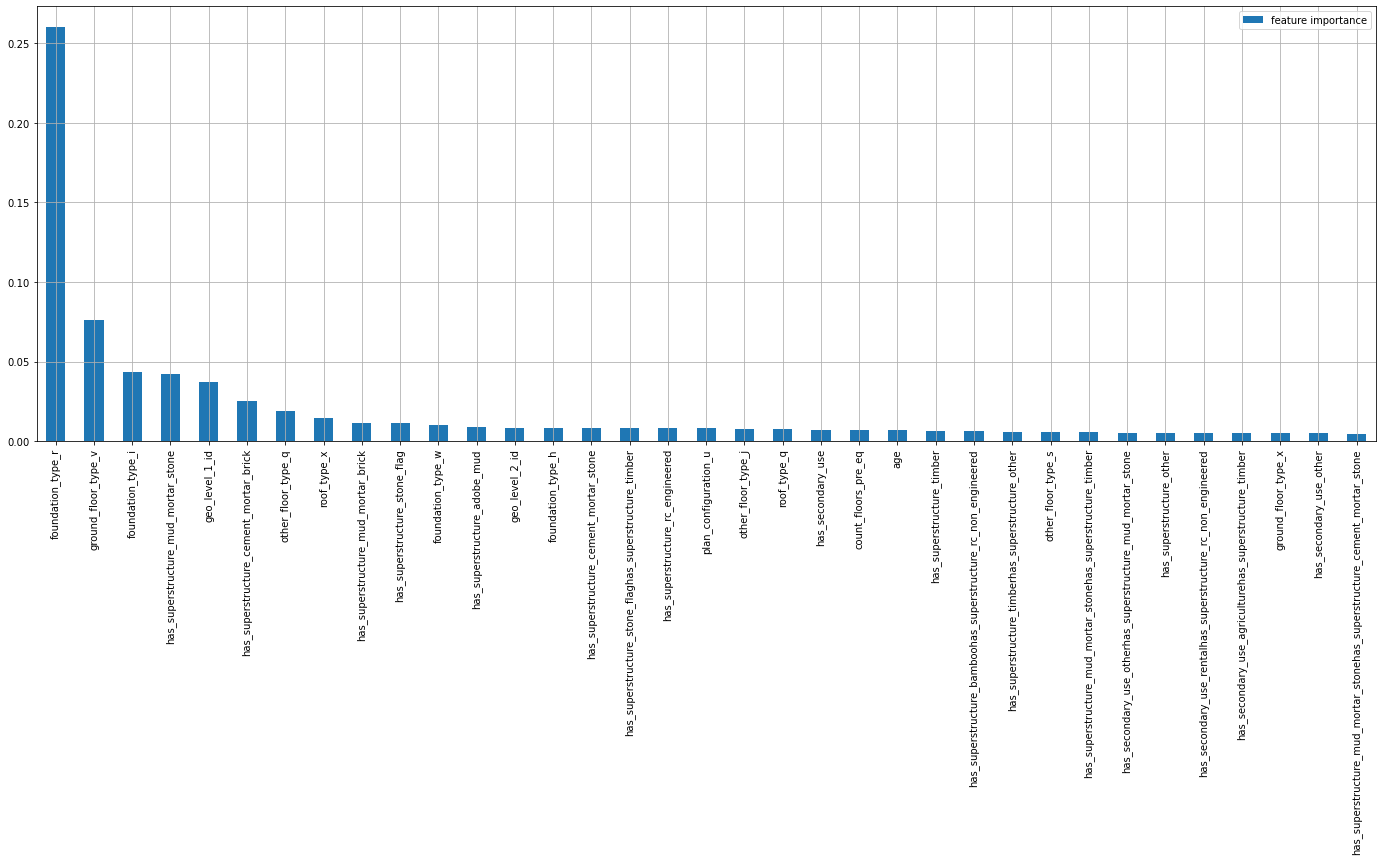

In [53]:
top_features.plot.bar(figsize = (24,8), grid=True)

In [ ]:
#Features estadisticos

In [8]:
num_cols

['geo_level_1_id',
 'geo_level_2_id',
 'geo_level_3_id',
 'count_floors_pre_eq',
 'age',
 'area_percentage',
 'height_percentage',
 'count_families',
 'weight']